In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt


In [4]:
stack_fixed = 'MD657'
stack_moving = 'atlasV3'

In [5]:
classifier_setting = 30
warp_setting = 1

In [6]:
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx,std_ty,std_tz,std_theta_xy,surround_weight,regularization_weight
warp_id,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,100,100,100,30,0,NaN
2,1,rigid,0.000010,100000.0,10000.0,100,100,100,30,0,NaN
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0,0.000001
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,inverse,0.000000
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0,NaN
10,None,rigid,0.000010,100000.0,1000.0,100,100,100,30,0,NaN
11,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.1,0.000000


In [7]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx = warp_properties['std_tx']
std_ty = warp_properties['std_ty']
std_tz = warp_properties['std_tz']
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy'])

upstream_warp_id                    None
transform_type                    affine
terminate_thresh                   1e-05
grad_computation_sample_number    100000
grid_search_sample_number           1000
std_tx                               100
std_ty                               100
std_tz                               100
std_theta_xy                          30
surround_weight                        0
regularization_weight                NaN
Name: 1, dtype: object


In [8]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score')

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_annotationVolume/atlasV3_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp


Child returned 0
Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp
(373, 430, 369)


Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (373, 430, 369)


In [9]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting, 
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

File does not exist: /shared/CSHL_volumes/MD657/MD657_down32_annotationVolume/MD657_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp


Child returned 0
Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp && mkdir -p /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp
(530, 862, 367)


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/MD657/MD657_down32_scoreVolume_clf_30/score_volumes/MD657_down32_scoreVolume_clf_30_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (530, 862, 367)


In [10]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 
                                   'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']}
#                      if name_m in ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 
#                                    'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R', 'Sp5C_L', 'LRt_R', 'IC']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [10]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [11]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [11]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [12]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [13]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

m: [ 215.   186.5  184.5] f: [ 215.   186.5  184.5]


In [14]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                                                          classifier_setting=classifier_setting)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [15]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 16, 21, 25, 26, 27, 28])


load gradient 2: 10.623826 seconds
load gradient 5: 7.229040 seconds
load gradient 7: 8.888030 seconds
load gradient 8: 7.325482 seconds
load gradient 16: 6.458480 seconds
load gradient 21: 12.369334 seconds
load gradient 25: 13.865664 seconds
load gradient 26: 15.897919 seconds
load gradient 27: 9.143570 seconds
load gradient 28: 9.370233 seconds
overall: 101.172563 seconds


In [16]:
aligner.set_label_weights(label_weights=label_weights_m)

In [17]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:

T_all_trials = []
scores_all_trials = []

for _ in range(5):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, 
                                     terminate_thresh=terminate_thresh,
                                     grid_search_iteration_number=30,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=10, lr2=0.1,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
                
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)

grid search: 5.707860 seconds
tx_best: 64.11 (voxel), ty_best: 73.20, tz_best: 10.25, theta_xy_best: -16.55 (deg)
sigma_tx: 100.00 (voxel), sigma_ty: 100.00, sigma_tz: 100.00, sigma_theta_xy: 30.00 (deg)
-inf 0.213544
grid search: 4.696569 seconds
tx_best: 75.96 (voxel), ty_best: 61.60, tz_best: 3.47, theta_xy_best: -11.82 (deg)
sigma_tx: 71.65 (voxel), sigma_ty: 71.65, sigma_tz: 71.65, sigma_theta_xy: 21.50 (deg)
0.213544 0.265271
grid search: 3.494266 seconds
tx_best: 75.96 (voxel), ty_best: 61.60, tz_best: 3.47, theta_xy_best: -11.82 (deg)
sigma_tx: 51.34 (voxel), sigma_ty: 51.34, sigma_tz: 51.34, sigma_theta_xy: 15.40 (deg)
grid search: 2.592424 seconds
tx_best: 75.96 (voxel), ty_best: 61.60, tz_best: 3.47, theta_xy_best: -11.82 (deg)
sigma_tx: 36.79 (voxel), sigma_ty: 36.79, sigma_tz: 36.79, sigma_theta_xy: 11.04 (deg)
grid search: 1.791013 seconds
tx_best: 87.58 (voxel), ty_best: 67.28, tz_best: 6.10, theta_xy_best: -9.57 (deg)
sigma_tx: 26.36 (voxel), sigma_ty: 26.36, sigma_tz: 

params_best_upToNow [ 90.76061264  65.80694577   2.81966798  -0.14340284]


step: 0.27 seconds
score: 0.278298
iteration 1
step: 0.26 seconds
score: 0.183044
iteration 2
step: 0.26 seconds
score: 0.201681
iteration 3
step: 0.26 seconds
score: 0.220737
iteration 4
step: 0.26 seconds
score: 0.226004
iteration 5
step: 0.26 seconds
score: 0.246073
iteration 6
step: 0.27 seconds
score: 0.227766
iteration 7
step: 0.27 seconds
score: 0.245643
iteration 8
step: 0.26 seconds
score: 0.265554
iteration 9
step: 0.26 seconds
score: 0.301136
iteration 10
step: 0.26 seconds
score: 0.292382
iteration 11
step: 0.26 seconds
score: 0.251202
iteration 12
step: 0.26 seconds
score: 0.305345
iteration 13
step: 0.26 seconds
score: 0.290792
iteration 14
step: 0.26 seconds
score: 0.274059
iteration 15
step: 0.26 seconds
score: 0.295957
iteration 16
step: 0.27 seconds
score: 0.301321
iteration 17
step: 0.26 seconds
score: 0.296757
iteration 18
step: 0.26 seconds
score: 0.301060
iteration 19
step: 0.26 seconds
score: 0.293738
iteration 20
step: 0.26 seconds
score: 0.306344
iteration 21
s

params_best_upToNow [ 95.58519443  64.02243852   3.53164252  -0.12729579]


step: 0.27 seconds
score: 0.277348
iteration 1
step: 0.26 seconds
score: 0.223311
iteration 2
step: 0.26 seconds
score: 0.154598
iteration 3
step: 0.26 seconds
score: 0.246179
iteration 4
step: 0.26 seconds
score: 0.207332
iteration 5
step: 0.26 seconds
score: 0.256434
iteration 6
step: 0.26 seconds
score: 0.254332
iteration 7
step: 0.26 seconds
score: 0.268410
iteration 8
step: 0.26 seconds
score: 0.293009
iteration 9
step: 0.26 seconds
score: 0.273001
iteration 10
step: 0.26 seconds
score: 0.276000
iteration 11
step: 0.26 seconds
score: 0.276784
iteration 12
step: 0.26 seconds
score: 0.291963
iteration 13
step: 0.27 seconds
score: 0.286977
iteration 14
step: 0.26 seconds
score: 0.282286
iteration 15
step: 0.26 seconds
score: 0.306554
iteration 16
step: 0.26 seconds
score: 0.283954
iteration 17
step: 0.26 seconds
score: 0.309515
iteration 18
step: 0.26 seconds
score: 0.296504
iteration 19
step: 0.26 seconds
score: 0.305969
iteration 20
step: 0.26 seconds
score: 0.292021
iteration 21
s

params_best_upToNow [ 88.8268516   64.1826902   -0.53409179  -0.12168227]


step: 0.26 seconds
score: 0.277425
iteration 1
step: 0.26 seconds
score: 0.147603
iteration 2
step: 0.26 seconds
score: 0.199118
iteration 3
step: 0.26 seconds
score: 0.235448
iteration 4
step: 0.26 seconds
score: 0.212906
iteration 5
step: 0.26 seconds
score: 0.206044
iteration 6
step: 0.26 seconds
score: 0.237616
iteration 7
step: 0.26 seconds
score: 0.229972
iteration 8
step: 0.26 seconds
score: 0.261268
iteration 9
step: 0.26 seconds
score: 0.266591
iteration 10
step: 0.26 seconds
score: 0.260589
iteration 11
step: 0.26 seconds
score: 0.242161
iteration 12
step: 0.26 seconds
score: 0.260773
iteration 13
step: 0.26 seconds
score: 0.241985
iteration 14
step: 0.26 seconds
score: 0.261804
iteration 15
step: 0.26 seconds
score: 0.254730
iteration 16
step: 0.26 seconds
score: 0.255465
iteration 17
step: 0.26 seconds
score: 0.254213
iteration 18
step: 0.26 seconds
score: 0.264094
iteration 19
step: 0.26 seconds
score: 0.261279
iteration 20
step: 0.26 seconds
score: 0.259354
iteration 21
s

step: 0.26 seconds
score: 0.297033
iteration 171
step: 0.26 seconds
score: 0.297381
iteration 172
step: 0.25 seconds
score: 0.297307
iteration 173
step: 0.25 seconds
score: 0.297478
iteration 174
step: 0.26 seconds
score: 0.297589
iteration 175
step: 0.25 seconds
score: 0.297188
iteration 176
step: 0.26 seconds
score: 0.297083
iteration 177
step: 0.25 seconds
score: 0.297333
iteration 178
step: 0.26 seconds
score: 0.297817
iteration 179
step: 0.26 seconds
score: 0.297060
iteration 180
step: 0.26 seconds
score: 0.297434
iteration 181
step: 0.25 seconds
score: 0.297405
iteration 182
step: 0.25 seconds
score: 0.297192
iteration 183
step: 0.25 seconds
score: 0.297805
iteration 184
step: 0.25 seconds
score: 0.297967
iteration 185
step: 0.25 seconds
score: 0.298000
iteration 186
step: 0.25 seconds
score: 0.297645
iteration 187
step: 0.26 seconds
score: 0.297894
iteration 188
step: 0.26 seconds
score: 0.297574
iteration 189
step: 0.25 seconds
score: 0.297670
iteration 190
step: 0.25 seconds
s

params_best_upToNow [ 92.6929213   64.73669176   3.24629293  -0.14186999]


step: 0.27 seconds
score: 0.278266
iteration 1
step: 0.26 seconds
score: 0.171691
iteration 2
step: 0.26 seconds
score: 0.168612
iteration 3
step: 0.26 seconds
score: 0.245665
iteration 4
step: 0.26 seconds
score: 0.231671
iteration 5
step: 0.26 seconds
score: 0.245426
iteration 6
step: 0.26 seconds
score: 0.282610
iteration 7
step: 0.26 seconds
score: 0.253409
iteration 8
step: 0.26 seconds
score: 0.274305
iteration 9
step: 0.26 seconds
score: 0.272829
iteration 10
step: 0.27 seconds
score: 0.261564
iteration 11
step: 0.26 seconds
score: 0.253303
iteration 12
step: 0.26 seconds
score: 0.300337
iteration 13
step: 0.26 seconds
score: 0.301520
iteration 14
step: 0.26 seconds
score: 0.284640
iteration 15
step: 0.26 seconds
score: 0.306171
iteration 16
step: 0.26 seconds
score: 0.291579
iteration 17
step: 0.26 seconds
score: 0.302108
iteration 18
step: 0.26 seconds
score: 0.286623
iteration 19
step: 0.26 seconds
score: 0.309074
iteration 20
step: 0.26 seconds
score: 0.293498
iteration 21
s

params_best_upToNow [ 96.03525742  62.58756343   0.33643234  -0.09655969]


step: 0.26 seconds
score: 0.278205
iteration 1
step: 0.26 seconds
score: 0.190901
iteration 2
step: 0.26 seconds
score: 0.175712
iteration 3
step: 0.26 seconds
score: 0.220434
iteration 4
step: 0.26 seconds
score: 0.219255
iteration 5
step: 0.26 seconds
score: 0.230032
iteration 6
step: 0.26 seconds
score: 0.255178
iteration 7
step: 0.26 seconds
score: 0.233072
iteration 8
step: 0.26 seconds
score: 0.265024
iteration 9
step: 0.26 seconds
score: 0.252793
iteration 10
step: 0.26 seconds
score: 0.248960
iteration 11
step: 0.25 seconds
score: 0.256809
iteration 12
step: 0.26 seconds
score: 0.258441
iteration 13
step: 0.26 seconds
score: 0.251773
iteration 14
step: 0.26 seconds
score: 0.261795
iteration 15
step: 0.26 seconds
score: 0.260595
iteration 16
step: 0.26 seconds
score: 0.263763
iteration 17
step: 0.26 seconds
score: 0.262930
iteration 18
step: 0.26 seconds
score: 0.263848
iteration 19
step: 0.26 seconds
score: 0.265157
iteration 20
step: 0.26 seconds
score: 0.264382
iteration 21
s

step: 0.26 seconds
score: 0.296286
iteration 171
step: 0.26 seconds
score: 0.295830
iteration 172
step: 0.25 seconds
score: 0.296839
iteration 173
step: 0.26 seconds
score: 0.297131
iteration 174
step: 0.26 seconds
score: 0.297250
iteration 175
step: 0.26 seconds
score: 0.297224
iteration 176
step: 0.26 seconds
score: 0.297159
iteration 177
step: 0.26 seconds
score: 0.297289
iteration 178
step: 0.26 seconds
score: 0.297522
iteration 179
step: 0.26 seconds
score: 0.297729
iteration 180
step: 0.26 seconds
score: 0.297496
iteration 181
step: 0.26 seconds
score: 0.297721
iteration 182
step: 0.26 seconds
score: 0.298035
iteration 183
step: 0.26 seconds
score: 0.297802
iteration 184
step: 0.26 seconds
score: 0.297697
iteration 185
step: 0.26 seconds
score: 0.298036
iteration 186
step: 0.26 seconds
score: 0.297813
iteration 187
step: 0.25 seconds
score: 0.298087
iteration 188
step: 0.26 seconds
score: 0.297923
iteration 189
step: 0.26 seconds
score: 0.298179
iteration 190
step: 0.26 seconds
s

In [67]:
# plt.plot(np.arange(30), std_tx*np.exp(-np.arange(30)/3.));
# plt.xlabel('Iteration');
# plt.ylabel('Search radius (voxel)');
# plt.title('Grid search radius shrinking schedule');
# plt.show();

inliers [0 1 3]
Widest standard deviation of converged translation parameters for different trials: 0.25 voxels, 3.74 um


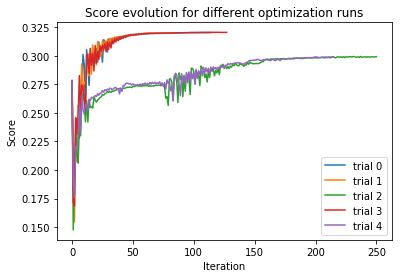

In [23]:
converged_scores = np.array([s[-1] for s in scores_all_trials])
q3 = np.percentile(converged_scores, 55)
q1 = np.percentile(converged_scores, 45)
iqr = q3 - q1
inlier_min = q1 - 1.5 * iqr
inlier_max = q3 + 1.5 * iqr
inliers = np.where((converged_scores > inlier_min) & (converged_scores < inlier_max))[0]
print 'inliers', inliers

plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different optimization runs');

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
T_all_trials = np.array(T_all_trials)
t_std = np.std(pca.fit_transform(T_all_trials[inliers[:,None] ,[3,7,11]])[0])
t_std_um = t_std * XY_PIXEL_DISTANCE_TB
print 'Widest standard deviation of converged translation parameters for different trials: %.2f voxels, %.2f um' % (t_std, t_std_um)

# tx_std = np.std(T_all_trials[inliers, 3])
# ty_std = np.std(T_all_trials[inliers, 7])
# tz_std = np.std(T_all_trials[inliers, 11])
# tx_std_um = tx_std * XY_PIXEL_DISTANCE_TB
# ty_std_um = ty_std * XY_PIXEL_DISTANCE_TB
# tz_std_um = tz_std * XY_PIXEL_DISTANCE_TB
# print 'tx std:', tx_std, 'voxels', tx_std_um, 'um'
# print 'ty std:', ty_std, 'voxels', ty_std_um, 'um'
# print 'tz std:', tz_std, 'voxels', tz_std_um, 'um'

# plt.scatter(np.ones((5,)), np.array(T_all_trials)[:, 3], marker='+');
# plt.scatter(2*np.ones((5,)), np.array(T_all_trials)[:, 7], marker='+');
# plt.scatter(3*np.ones((5,)), np.array(T_all_trials)[:, 11], marker='+');

Best trial: 3
0.32058906788 0.320520204958
[[  9.06684899e-01   1.93451689e-01   9.88171780e-02   8.59933755e+01]
 [ -1.37658920e-01   9.50057243e-01  -3.16016873e-02   5.68289625e+01]
 [ -8.98348243e-02   4.20361946e-02   9.88632774e-01  -6.79708841e+00]]


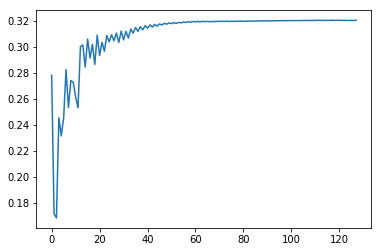

In [24]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [22]:
# print T.reshape((3,4))
# plt.plot(scores);
# print max(scores), scores[-1]

# Export parameters and score plots

In [25]:
for trial_idx in range(5):
    
    T = T_all_trials[trial_idx]
    scores = scores_all_trials[trial_idx]
    
    params_fp = \
    DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  trial_idx=trial_idx)
    DataManager.save_alignment_parameters(params_fp, T, 
                                          aligner.centroid_m, aligner.centroid_f,
                                          aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                          aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
    upload_from_ec2_to_s3(params_fp)
    
    history_fp = DataManager.get_score_history_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                          classifier_setting_m=classifier_setting,
                                                          classifier_setting_f=classifier_setting,
                                                          warp_setting=warp_setting,
                                                          trial_idx=trial_idx)
    bp.pack_ndarray_file(np.array(scores), history_fp)
    upload_from_ec2_to_s3(history_fp)

    score_plot_fp = \
    DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                         classifier_setting_m=classifier_setting,
                                                         classifier_setting_f=classifier_setting,
                                                         warp_setting=warp_setting,
                                                         trial_idx=trial_idx)
    fig = plt.figure();
    plt.plot(scores);
    plt.savefig(score_plot_fp, bbox_inches='tight')
    plt.close(fig)

    upload_from_ec2_to_s3(score_plot_fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_parameters.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreHistory.bp


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png


Child returned 0
0.64 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1_parameters.txt


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1_scoreHistory.bp


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_1_scoreEvolution.png


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2_parameters.txt


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2_scoreHistory.bp


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_2_scoreEvolution.png


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3_parameters.txt


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3_scoreHistory.bp


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_3_scoreEvolution.png


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4_parameters.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4_scoreHistory.bp


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_4_scoreEvolution.png


Child returned 0
0.45 seconds.


# Draw Results

In [34]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [36]:
# # Transform moving volume, sided, without surround

# structure = '5N_L'

# vol_m = DataManager.load_volume(stack=stack_moving, structure=structure, downscale=32)

# volume_m_alignedTo_f = \
# transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
#                   xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [37]:
# # Set colors for different contour level
# levels = [0.1, 0.25, 0.5, 0.75, .99]
# level_colors = {level: (int(level*255),0,0) for level in levels}

In [42]:
# # Generate overlay visualization

# # For getting correct contour location

# # xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
# # DataManager.load_volume_bbox(stack=stack_fixed, type='score', structure='7N', 
# #                              downscale=32, classifier_setting=classifier_setting)
# # print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f = DataManager.load_cropbox(stack=stack_fixed)[:4]

# # Generate atlas overlay image for every section

# zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
# sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
# sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

# for sec in range(sec_first, sec_last+1):
# # for sec in [155]:
    
#     if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
#         continue
    
#     try:
#         img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#         img = imread(img_fn)
# #         img = imread(DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
# #                                                            downscale=32,
# #                                                            structure=convert_to_original_name(structure), 
# #                                                            setting=classifier_setting))
#     except:
#         sys.stderr.write('Error loading scoremap for section %d\n' % sec)
#         continue
    
#     viz = img.copy()
    
#     z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
#     z = int(z1)
    
#     # Find moving volume annotation contours
#     c = 0
#     vol = volume_m_alignedTo_f
#     for level in levels:
#         cnts = find_contours(vol[..., z], level=level) # rows, cols
#         c += len(cnts)
#         for cnt in cnts:
#             # r,c to x,y
#             cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
#             cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
#     if c > 0:    
# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
#         plt.imshow(viz);
#         plt.show();


Error loading scoremap for section 143
Error loading scoremap for section 144
Error loading scoremap for section 145
Error loading scoremap for section 146
Error loading scoremap for section 147
Error loading scoremap for section 148
Error loading scoremap for section 149
Error loading scoremap for section 150
Error loading scoremap for section 151
Error loading scoremap for section 152
Error loading scoremap for section 153
Error loading scoremap for section 154
Error loading scoremap for section 155
Error loading scoremap for section 156
Error loading scoremap for section 157
Error loading scoremap for section 158
Error loading scoremap for section 159
Error loading scoremap for section 160
Error loading scoremap for section 161
Error loading scoremap for section 162
Error loading scoremap for section 163
Error loading scoremap for section 164
Error loading scoremap for section 165
Error loading scoremap for section 166
Error loading scoremap for section 167
Error loading scoremap fo